In [3]:
import glob
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D,MaxPooling1D,\
GlobalAveragePooling1D, Flatten,Lambda ,Reshape ,Conv1DTranspose,Activation
from tensorflow.keras.losses import mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
%matplotlib inline


In [4]:
#Reading the patient DNA sequence
patient_data = pd.read_csv('BRCA1_gene_sequence_patient.txt',header=None)

#Reading the reference DNA sequence
reference_data = pd.read_csv('BRCA1_gene_sequence.txt', header=None)

#Reading the reference exon boundaries
exon_boundaries = pd.read_csv('BRCA1_exon_bounderies.csv')

In [5]:
def vectorize(seq):
    """
    Vectorize the the DNA sequence 
    """
    str_sequence = ''
    arr_sequence = []
    #Concatenate lines of strings
    for line in seq[0]:
         str_sequence += line
    #Populate the vector with the nucleotides
    for n in str_sequence:
        arr_sequence.append(n)
    return np.array(arr_sequence)

In [6]:
# Find the length of the longest exon
EXON_MAX_LENGTH = 0
for i in range(len(exon_boundaries)):
    start = exon_boundaries.loc[i].start
    end = exon_boundaries.loc[i].end
    diff = end - start + 1
    if diff > EXON_MAX_LENGTH:
        EXON_MAX_LENGTH = diff

In [7]:
#Vectorize the referent and patient data
ref_vec = vectorize(reference_data)
pat_vec = vectorize(patient_data)

In [8]:
def normalize(seq):
    """
    Normalize the sequence
    """
    return seq / np.max(seq)

In [9]:
def nucleotide_to_num(sequence):
    """
    Transforms DNA sequence to a sequence of numbers coresponding to certain nucleotide
    """
    ref_sequence_to_num = []
    nucleotide_to_num = {
        'A': 1.,
        'C': 2.,
        'G': 3.,
        'T': 4.,
        'N': 5.
    }
    for nucleodtide in sequence:
            ref_sequence_to_num.append(nucleotide_to_num[nucleodtide])

    return np.array(normalize(ref_sequence_to_num))

In [10]:
#following function for extracting the exons and make their length even number because 
#the nature of the autoencoder
def split_exons(seq):
    """Devide the DNA sequence on exons - remove the other parts"""
    exon_seq = []
    for i in range(len(exon_boundaries)):
        start = exon_boundaries.loc[i].start
        end = exon_boundaries.loc[i].end
        ex = seq[start : end]
        # Making the length of the exons to be even number
        if len(ex) % 2 != 0:
            ex = np.hstack((ex , ['N' for _ in range(1)]))
        exon_seq.append(nucleotide_to_num(ex))
    return exon_seq

In [11]:
#Extracting exons for the referent and patient sets
referent_exons = split_exons(ref_vec)
patient_exons = split_exons(pat_vec)

In [12]:
COPY_COUNT = 300
def create_dataset(X):
    """Create an 3D array with multiple copies of given sequence"""
    Xs=[]
    for i in range(COPY_COUNT):
        Xs.append(X)
    return np.array(Xs)

## Convolutional reconstruction autoencoder 
we will train the model with the referent (healthy) DNA sequence. After that tha model should be able to detect the potential changes in the patient DNA. 
So, the encoder will first encode the sequence into a lower dimentional latent representation. Then decode it back to the sequence. 

In [13]:
KRNL_SIZE = 7
latent_dim = 20
class MutationDetector(Model):
    """
    Capsulate an autoencoder in a class.
    This way it can be used multiple times as separate object.
    """
    def __init__(self, input_a):
        super(MutationDetector, self).__init__()
        
        #Encoder part 
        inputs = Input(shape=(input_a, 1))

        conv = Conv1D(
            filters=8, kernel_size=KRNL_SIZE, strides=2, padding="same", activation = 'relu')(inputs)
        

        conv = Conv1D(
            filters=4, kernel_size=KRNL_SIZE, strides=1, padding="same", activation="relu")(conv)

        """
        Storing the shape of the last convolutional layer
        to use it in the decoder part
        """
        vol_size = K.int_shape(conv)
        
        """
        Flatten the convolutional output to a 1d lattent space
        Pass it to a dense layer
        """
        flat = Flatten()(conv)
        latent = Dense(latent_dim)(flat)
        
        #Decoder part 

        dense = Dense(np.prod(vol_size[1:]))(latent)
        reshape = Reshape((vol_size[1], vol_size[2]))(dense)

        conv_trans = Conv1DTranspose(
            filters=4, kernel_size=KRNL_SIZE, strides=1, padding="same", activation = 'relu')(reshape)
        
        conv_trans = Conv1DTranspose(
            filters=8, kernel_size=KRNL_SIZE, strides=2,padding="same", activation = 'relu')(conv_trans)
        
        outputs = Conv1DTranspose(
            filters=1, kernel_size=KRNL_SIZE, padding="same", activation='sigmoid')(conv_trans)
        self.autoencoder = Model(inputs, outputs)
        
    def call(self, x):
        return self.autoencoder(x)
    
    def show_summary(self):
        #Returns the summary of the current object
        return self.autoencoder.summary()

In [14]:
def training_plot(hist,title):
    """
    Plot training and validation losses
    """
    fig, ax = plt.subplots(figsize=(6, 3), dpi=80)
    plt.plot(hist.history['loss'], label='Training loss')
    plt.plot(hist.history['val_loss'], label='Validation loss')
    ax.set_title(title)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    plt.legend()
    plt.show()

In [15]:
def calculate_threshold(predicted, referent):
    """
    Calculating train loss and threshold
    """
    train_loss = np.mean(np.abs(predicted - referent), axis=1) 
    threshold = np.max(train_loss)
    plt.hist(train_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()
    
    return threshold

In [16]:
anomalous_exon_names = []

def detect_anomalies(predicted, referent,threshold, exon_name):
    """
    Detect the samples which are anomalies.
    Calculate mean absolute error
    """
    test_loss = np.mean(np.abs(predicted - referent), axis=1)
    print('Anomaly detection - {}'.format(exon_name))
    
    # Finding the anomalies
    anomalies = test_loss > threshold
    anomaly_sum =  np.sum(anomalies)
    print("Count of anomalous nucleotides: ", anomaly_sum)
    
    #Print the anomaly nucleotide position 
    if anomaly_sum > 0:
        anomalous_exon_names.append(exon_name)
        print("Position of anomalous nucleotide: ", np.where(anomalies))
        print("Test losses {}".format(test_loss[np.where(anomalies)]))

===========Training for exon_01============
Epoch 1/30
15/15 - 9s - loss: 0.1767 - val_loss: 0.1680 - 9s/epoch - 625ms/step
Epoch 2/30
15/15 - 0s - loss: 0.1509 - val_loss: 0.1281 - 214ms/epoch - 14ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1095 - val_loss: 0.0892 - 199ms/epoch - 13ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0752 - val_loss: 0.0621 - 205ms/epoch - 14ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0522 - val_loss: 0.0423 - 201ms/epoch - 13ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0373 - val_loss: 0.0330 - 235ms/epoch - 16ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0301 - val_loss: 0.0271 - 257ms/epoch - 17ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0239 - val_loss: 0.0210 - 203ms/epoch - 14ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0190 - val_loss: 0.0167 - 200ms/epoch - 13ms/step
Epoch 10/30
15/15 - 0s - loss: 0.0153 - val_loss: 0.0139 - 218ms/epoch - 15ms/step
Epoch 11/30
15/15 - 0s - loss: 0.0123 - val_loss: 0.0108 - 232ms/epoch - 15ms/step
Epoch 12/30
15/15 - 0s - loss: 0.0097 - val_loss: 0.00

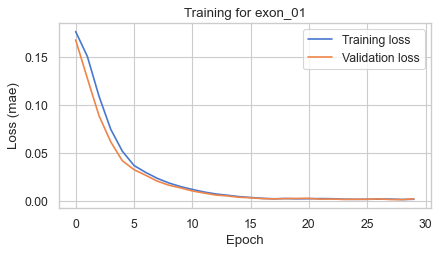

10/10 [==============================] - 0s 5ms/step


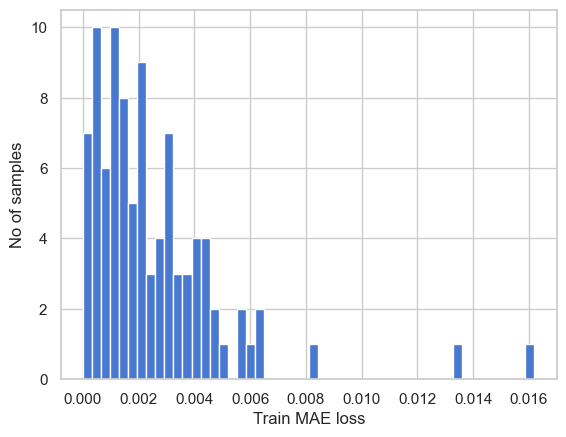

Reconstruction error threshold: 0.01619112491607666
1/1 [==============================] - 0s 43ms/step
Anomaly detection - exon_01
Count of anomalous nucleotides:  0
======== End of processing exon_01 ========  

===========Training for exon_02============
Epoch 1/30
15/15 - 2s - loss: 0.2814 - val_loss: 0.2682 - 2s/epoch - 166ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2337 - val_loss: 0.1864 - 154ms/epoch - 10ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1515 - val_loss: 0.1138 - 148ms/epoch - 10ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0948 - val_loss: 0.0788 - 151ms/epoch - 10ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0671 - val_loss: 0.0553 - 151ms/epoch - 10ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0478 - val_loss: 0.0414 - 149ms/epoch - 10ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0371 - val_loss: 0.0341 - 182ms/epoch - 12ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0313 - val_loss: 0.0292 - 173ms/epoch - 12ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0280 - val_loss: 0.0256 - 171ms/epoch - 11ms/step
Epoch 

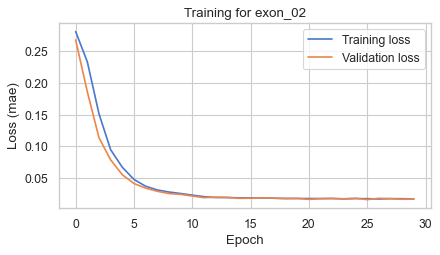

10/10 [==============================] - 0s 5ms/step


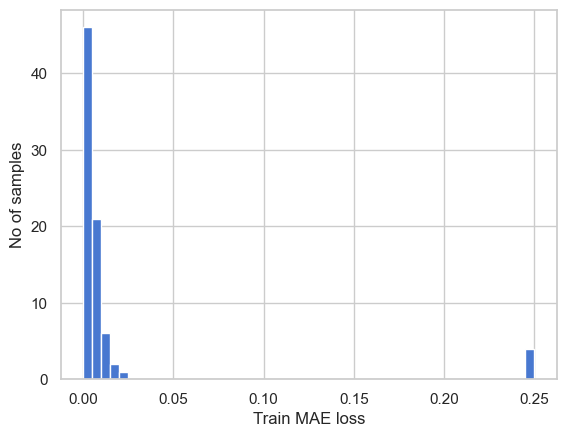

Reconstruction error threshold: 0.24999994039535522
1/1 [==============================] - 0s 30ms/step
Anomaly detection - exon_02
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([0]),)
Test losses [0.50170176]
======== End of processing exon_02 ========  

===========Training for exon_03============
Epoch 1/30
15/15 - 2s - loss: 0.2585 - val_loss: 0.2484 - 2s/epoch - 154ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2250 - val_loss: 0.1894 - 125ms/epoch - 8ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1684 - val_loss: 0.1370 - 125ms/epoch - 8ms/step
Epoch 4/30
15/15 - 0s - loss: 0.1159 - val_loss: 0.0975 - 125ms/epoch - 8ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0861 - val_loss: 0.0762 - 125ms/epoch - 8ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0708 - val_loss: 0.0670 - 129ms/epoch - 9ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0628 - val_loss: 0.0590 - 158ms/epoch - 11ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0569 - val_loss: 0.0544 - 153ms/epoch - 10ms/step
Epoch 9/30
15/15 - 

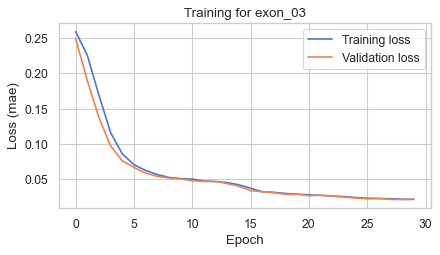

10/10 [==============================] - 0s 4ms/step


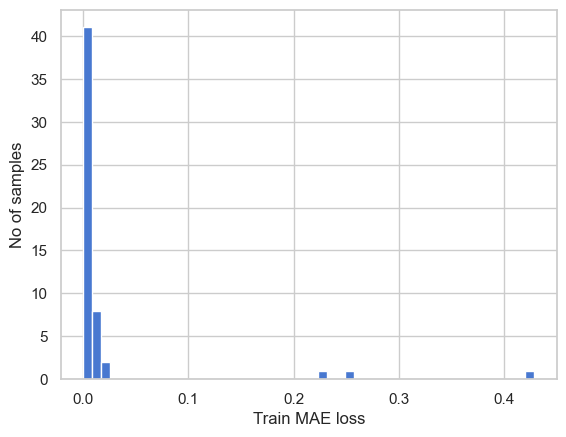

Reconstruction error threshold: 0.4289427399635315
1/1 [==============================] - 0s 29ms/step
Anomaly detection - exon_03
Count of anomalous nucleotides:  0
======== End of processing exon_03 ========  

===========Training for exon_04============
Epoch 1/30
15/15 - 2s - loss: 0.2677 - val_loss: 0.2636 - 2s/epoch - 136ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2459 - val_loss: 0.2088 - 144ms/epoch - 10ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1715 - val_loss: 0.1366 - 142ms/epoch - 9ms/step
Epoch 4/30
15/15 - 0s - loss: 0.1108 - val_loss: 0.0857 - 140ms/epoch - 9ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0725 - val_loss: 0.0608 - 143ms/epoch - 10ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0518 - val_loss: 0.0421 - 132ms/epoch - 9ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0374 - val_loss: 0.0327 - 134ms/epoch - 9ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0290 - val_loss: 0.0272 - 135ms/epoch - 9ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0250 - val_loss: 0.0231 - 136ms/epoch - 9ms/step
Epoch 10/30
1

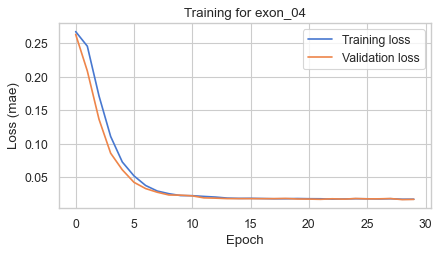

10/10 [==============================] - 0s 5ms/step


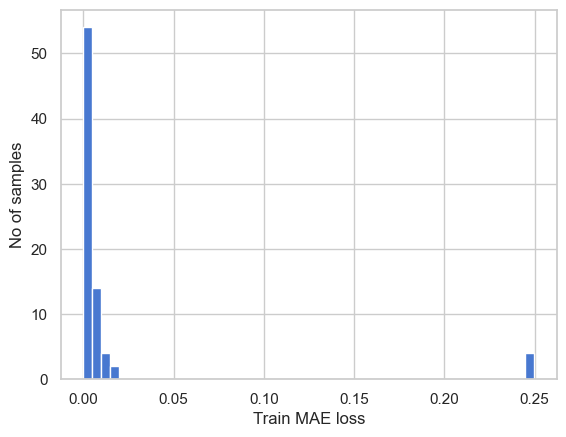

Reconstruction error threshold: 0.24972784519195557
1/1 [==============================] - 0s 30ms/step
Anomaly detection - exon_04
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([19]),)
Test losses [0.26967764]
======== End of processing exon_04 ========  

===========Training for exon_05============
Epoch 1/30
15/15 - 2s - loss: 0.2224 - val_loss: 0.2126 - 2s/epoch - 144ms/step
Epoch 2/30
15/15 - 0s - loss: 0.1877 - val_loss: 0.1506 - 146ms/epoch - 10ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1279 - val_loss: 0.1038 - 145ms/epoch - 10ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0837 - val_loss: 0.0618 - 142ms/epoch - 9ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0507 - val_loss: 0.0391 - 144ms/epoch - 10ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0316 - val_loss: 0.0232 - 143ms/epoch - 10ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0191 - val_loss: 0.0148 - 144ms/epoch - 10ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0129 - val_loss: 0.0103 - 155ms/epoch - 10ms/step
Epoch 9/30
15/

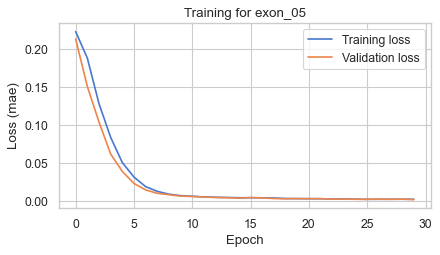

10/10 [==============================] - 0s 5ms/step


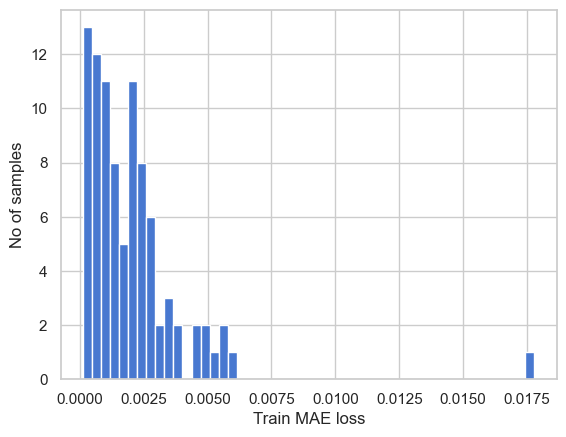

Reconstruction error threshold: 0.01778101921081543
1/1 [==============================] - 0s 27ms/step
Anomaly detection - exon_05
Count of anomalous nucleotides:  0
======== End of processing exon_05 ========  

===========Training for exon_06============
Epoch 1/30
15/15 - 2s - loss: 0.2513 - val_loss: 0.2422 - 2s/epoch - 144ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2174 - val_loss: 0.1811 - 158ms/epoch - 11ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1520 - val_loss: 0.1236 - 166ms/epoch - 11ms/step
Epoch 4/30
15/15 - 0s - loss: 0.1026 - val_loss: 0.0819 - 177ms/epoch - 12ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0684 - val_loss: 0.0543 - 164ms/epoch - 11ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0462 - val_loss: 0.0377 - 163ms/epoch - 11ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0347 - val_loss: 0.0304 - 162ms/epoch - 11ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0288 - val_loss: 0.0284 - 169ms/epoch - 11ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0261 - val_loss: 0.0246 - 158ms/epoch - 11ms/step
Epoch 

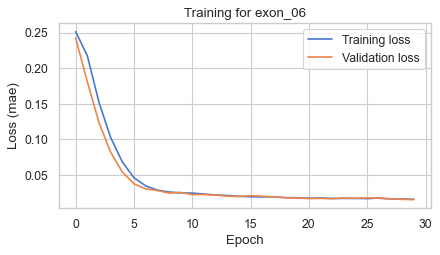

10/10 [==============================] - 0s 6ms/step


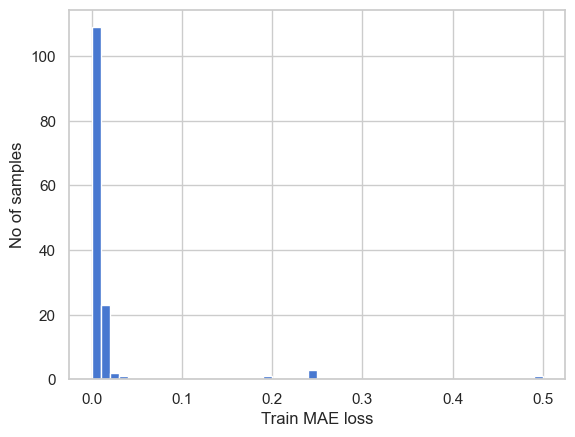

Reconstruction error threshold: 0.4999959468841553
1/1 [==============================] - 0s 26ms/step
Anomaly detection - exon_06
Count of anomalous nucleotides:  0
======== End of processing exon_06 ========  

===========Training for exon_07============
Epoch 1/30
15/15 - 2s - loss: 0.2418 - val_loss: 0.2393 - 2s/epoch - 157ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2310 - val_loss: 0.2120 - 145ms/epoch - 10ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1729 - val_loss: 0.1359 - 131ms/epoch - 9ms/step
Epoch 4/30
15/15 - 0s - loss: 0.1145 - val_loss: 0.0920 - 130ms/epoch - 9ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0802 - val_loss: 0.0686 - 126ms/epoch - 8ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0625 - val_loss: 0.0563 - 128ms/epoch - 9ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0511 - val_loss: 0.0455 - 127ms/epoch - 8ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0417 - val_loss: 0.0381 - 125ms/epoch - 8ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0352 - val_loss: 0.0316 - 126ms/epoch - 8ms/step
Epoch 10/30
15

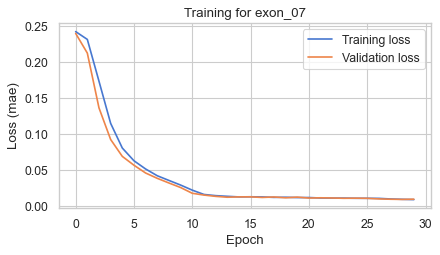

10/10 [==============================] - 0s 4ms/step


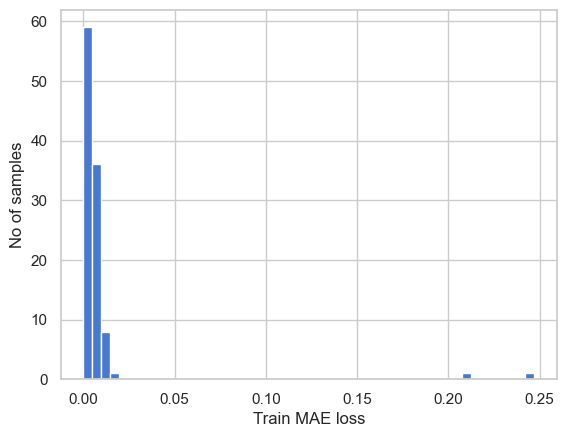

Reconstruction error threshold: 0.2470551929436624
1/1 [==============================] - 0s 28ms/step
Anomaly detection - exon_07
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([27]),)
Test losses [0.49294102]
======== End of processing exon_07 ========  

===========Training for exon_08============
Epoch 1/30
15/15 - 2s - loss: 0.2101 - val_loss: 0.1906 - 2s/epoch - 128ms/step
Epoch 2/30
15/15 - 0s - loss: 0.1733 - val_loss: 0.1507 - 126ms/epoch - 8ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1294 - val_loss: 0.1076 - 127ms/epoch - 8ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0961 - val_loss: 0.0841 - 129ms/epoch - 9ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0753 - val_loss: 0.0649 - 128ms/epoch - 9ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0570 - val_loss: 0.0478 - 126ms/epoch - 8ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0418 - val_loss: 0.0360 - 126ms/epoch - 8ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0317 - val_loss: 0.0268 - 126ms/epoch - 8ms/step
Epoch 9/30
15/15 - 0s

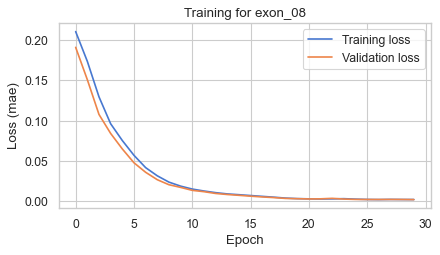

10/10 [==============================] - 0s 4ms/step


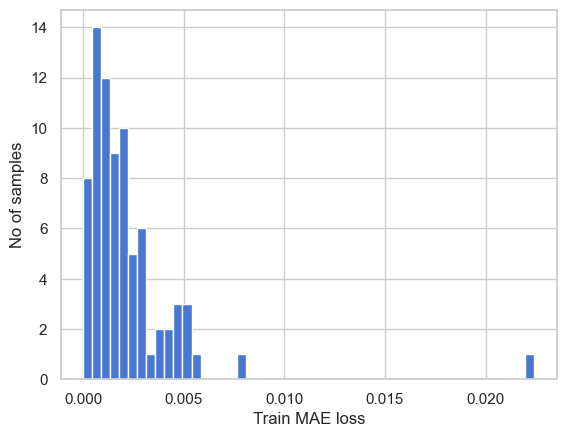

Reconstruction error threshold: 0.022420108318328857
1/1 [==============================] - 0s 28ms/step
Anomaly detection - exon_08
Count of anomalous nucleotides:  0
======== End of processing exon_08 ========  

===========Training for exon_09============
Epoch 1/30
15/15 - 2s - loss: 0.1981 - val_loss: 0.1848 - 2s/epoch - 141ms/step
Epoch 2/30
15/15 - 0s - loss: 0.1661 - val_loss: 0.1413 - 138ms/epoch - 9ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1199 - val_loss: 0.0987 - 133ms/epoch - 9ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0838 - val_loss: 0.0671 - 135ms/epoch - 9ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0576 - val_loss: 0.0492 - 137ms/epoch - 9ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0438 - val_loss: 0.0380 - 138ms/epoch - 9ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0328 - val_loss: 0.0281 - 142ms/epoch - 9ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0244 - val_loss: 0.0210 - 136ms/epoch - 9ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0193 - val_loss: 0.0171 - 137ms/epoch - 9ms/step
Epoch 10/30
1

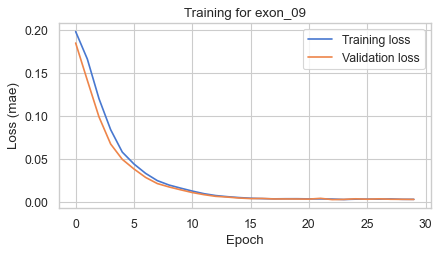

10/10 [==============================] - 0s 5ms/step


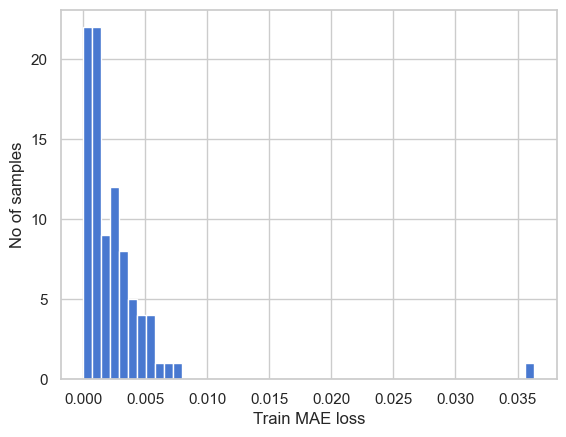

Reconstruction error threshold: 0.0363425612449646
1/1 [==============================] - 0s 25ms/step
Anomaly detection - exon_09
Count of anomalous nucleotides:  0
======== End of processing exon_09 ========  

===========Training for exon_10============
Epoch 1/30
15/15 - 2s - loss: 0.2310 - val_loss: 0.2258 - 2s/epoch - 146ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2003 - val_loss: 0.1555 - 156ms/epoch - 10ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1314 - val_loss: 0.1061 - 149ms/epoch - 10ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0944 - val_loss: 0.0823 - 154ms/epoch - 10ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0728 - val_loss: 0.0638 - 158ms/epoch - 11ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0579 - val_loss: 0.0528 - 153ms/epoch - 10ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0492 - val_loss: 0.0463 - 157ms/epoch - 10ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0434 - val_loss: 0.0408 - 156ms/epoch - 10ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0389 - val_loss: 0.0362 - 152ms/epoch - 10ms/step
Epoch 1

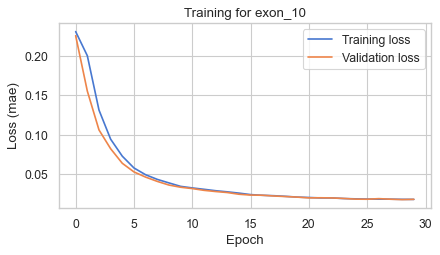

10/10 [==============================] - 0s 5ms/step


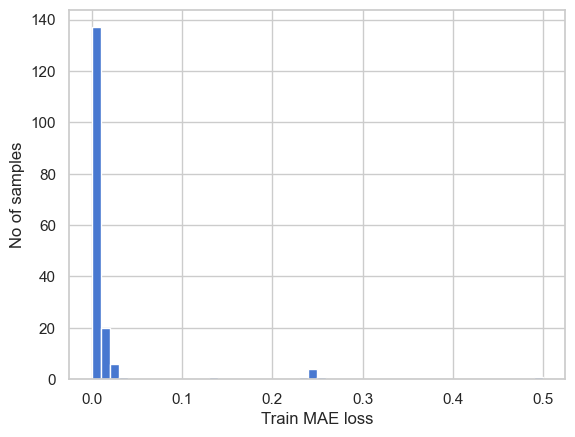

Reconstruction error threshold: 0.49952077865600586
1/1 [==============================] - 0s 25ms/step
Anomaly detection - exon_10
Count of anomalous nucleotides:  0
======== End of processing exon_10 ========  

===========Training for exon_11============
Epoch 1/30
15/15 - 2s - loss: 0.2123 - val_loss: 0.1922 - 2s/epoch - 131ms/step
Epoch 2/30
15/15 - 0s - loss: 0.1654 - val_loss: 0.1426 - 139ms/epoch - 9ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1284 - val_loss: 0.1149 - 136ms/epoch - 9ms/step
Epoch 4/30
15/15 - 0s - loss: 0.1023 - val_loss: 0.0869 - 139ms/epoch - 9ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0753 - val_loss: 0.0644 - 141ms/epoch - 9ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0574 - val_loss: 0.0507 - 138ms/epoch - 9ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0460 - val_loss: 0.0407 - 135ms/epoch - 9ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0365 - val_loss: 0.0322 - 136ms/epoch - 9ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0297 - val_loss: 0.0268 - 139ms/epoch - 9ms/step
Epoch 10/30
15

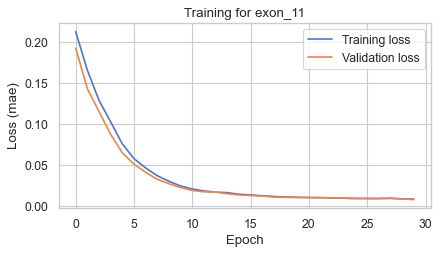

10/10 [==============================] - 0s 5ms/step


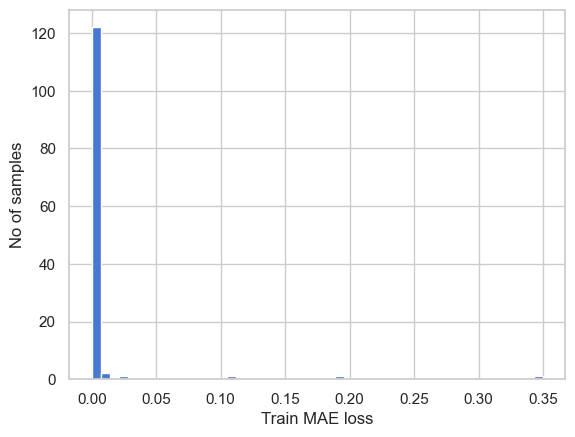

Reconstruction error threshold: 0.3496632635593414
1/1 [==============================] - 0s 25ms/step
Anomaly detection - exon_11
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([70]),)
Test losses [0.35035372]
======== End of processing exon_11 ========  

===========Training for exon_12============
Epoch 1/30
15/15 - 2s - loss: 0.1983 - val_loss: 0.1796 - 2s/epoch - 132ms/step
Epoch 2/30
15/15 - 0s - loss: 0.1566 - val_loss: 0.1301 - 156ms/epoch - 10ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1143 - val_loss: 0.0978 - 158ms/epoch - 11ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0866 - val_loss: 0.0750 - 157ms/epoch - 10ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0670 - val_loss: 0.0576 - 160ms/epoch - 11ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0516 - val_loss: 0.0460 - 157ms/epoch - 10ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0412 - val_loss: 0.0362 - 161ms/epoch - 11ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0319 - val_loss: 0.0279 - 167ms/epoch - 11ms/step
Epoch 9/30
15/

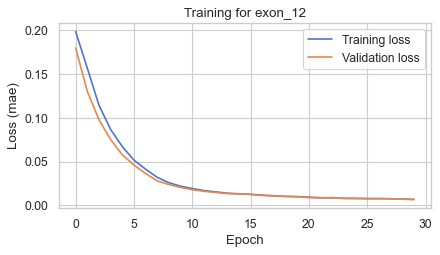

10/10 [==============================] - 0s 5ms/step


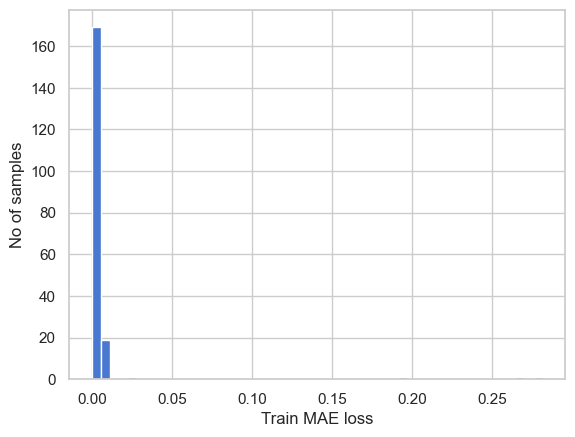

Reconstruction error threshold: 0.2816860556602478
1/1 [==============================] - 0s 27ms/step
Anomaly detection - exon_12
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([119]),)
Test losses [0.28179817]
======== End of processing exon_12 ========  

===========Training for exon_13============
Epoch 1/30
15/15 - 2s - loss: 0.2036 - val_loss: 0.1990 - 2s/epoch - 149ms/step
Epoch 2/30
15/15 - 0s - loss: 0.1782 - val_loss: 0.1495 - 201ms/epoch - 13ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1265 - val_loss: 0.1048 - 198ms/epoch - 13ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0893 - val_loss: 0.0743 - 242ms/epoch - 16ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0634 - val_loss: 0.0528 - 205ms/epoch - 14ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0467 - val_loss: 0.0407 - 209ms/epoch - 14ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0371 - val_loss: 0.0338 - 207ms/epoch - 14ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0315 - val_loss: 0.0292 - 217ms/epoch - 14ms/step
Epoch 9/30
15

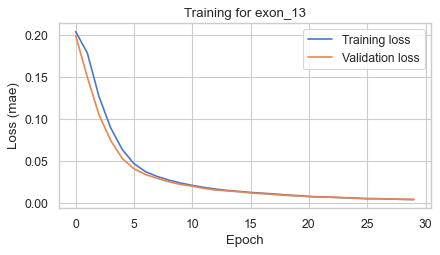

10/10 [==============================] - 0s 6ms/step


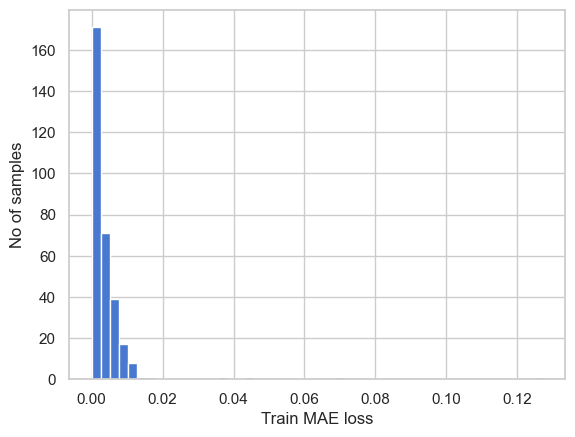

Reconstruction error threshold: 0.1272056341171265
1/1 [==============================] - 0s 27ms/step
Anomaly detection - exon_13
Count of anomalous nucleotides:  2
Position of anomalous nucleotide:  (array([125, 165]),)
Test losses [0.59257408 0.12871044]
======== End of processing exon_13 ========  

===========Training for exon_14============
Epoch 1/30
15/15 - 2s - loss: 0.2649 - val_loss: 0.2533 - 2s/epoch - 167ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2209 - val_loss: 0.1817 - 142ms/epoch - 9ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1574 - val_loss: 0.1282 - 122ms/epoch - 8ms/step
Epoch 4/30
15/15 - 0s - loss: 0.1088 - val_loss: 0.0843 - 122ms/epoch - 8ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0666 - val_loss: 0.0519 - 123ms/epoch - 8ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0431 - val_loss: 0.0342 - 122ms/epoch - 8ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0320 - val_loss: 0.0289 - 122ms/epoch - 8ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0282 - val_loss: 0.0292 - 122ms/epoch - 8ms/step
Epoc

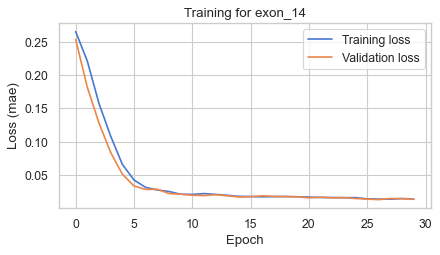

10/10 [==============================] - 0s 5ms/step


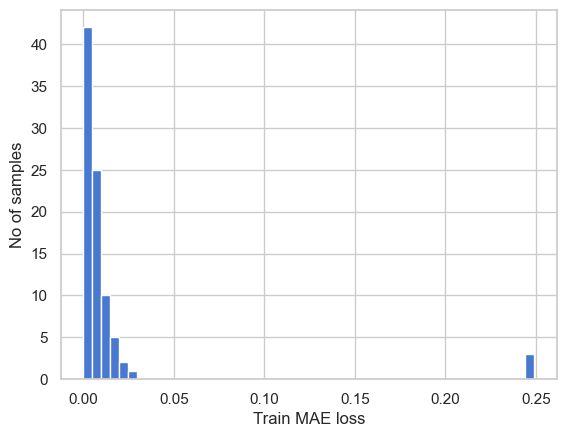

Reconstruction error threshold: 0.2491247057914734
1/1 [==============================] - 0s 34ms/step
Anomaly detection - exon_14
Count of anomalous nucleotides:  1
Position of anomalous nucleotide:  (array([4]),)
Test losses [0.49502593]
======== End of processing exon_14 ========  

===========Training for exon_15============
Epoch 1/30
15/15 - 2s - loss: 0.3009 - val_loss: 0.2883 - 2s/epoch - 166ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2542 - val_loss: 0.2074 - 166ms/epoch - 11ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1842 - val_loss: 0.1575 - 161ms/epoch - 11ms/step
Epoch 4/30
15/15 - 0s - loss: 0.1393 - val_loss: 0.1189 - 164ms/epoch - 11ms/step
Epoch 5/30
15/15 - 0s - loss: 0.1020 - val_loss: 0.0847 - 154ms/epoch - 10ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0749 - val_loss: 0.0658 - 199ms/epoch - 13ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0604 - val_loss: 0.0543 - 178ms/epoch - 12ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0502 - val_loss: 0.0452 - 173ms/epoch - 12ms/step
Epoch 9/30
15/1

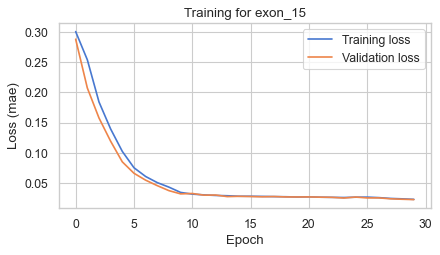

10/10 [==============================] - 0s 4ms/step


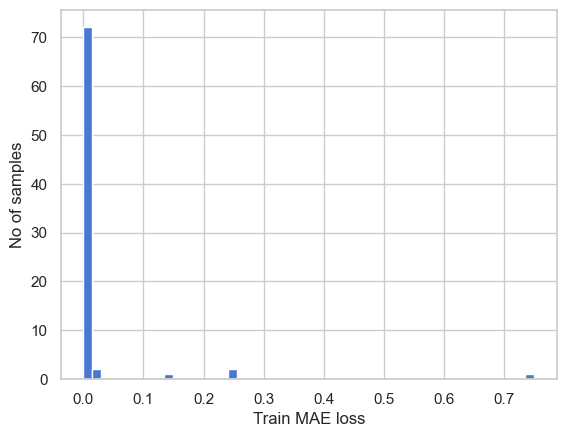

Reconstruction error threshold: 0.7499580383300781
1/1 [==============================] - 0s 28ms/step
Anomaly detection - exon_15
Count of anomalous nucleotides:  0
======== End of processing exon_15 ========  

===========Training for exon_16============
Epoch 1/30
15/15 - 2s - loss: 0.2227 - val_loss: 0.2120 - 2s/epoch - 135ms/step
Epoch 2/30
15/15 - 0s - loss: 0.1843 - val_loss: 0.1385 - 121ms/epoch - 8ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1076 - val_loss: 0.0734 - 112ms/epoch - 7ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0569 - val_loss: 0.0458 - 115ms/epoch - 8ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0385 - val_loss: 0.0317 - 112ms/epoch - 7ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0267 - val_loss: 0.0231 - 111ms/epoch - 7ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0214 - val_loss: 0.0192 - 111ms/epoch - 7ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0177 - val_loss: 0.0160 - 112ms/epoch - 7ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0152 - val_loss: 0.0146 - 111ms/epoch - 7ms/step
Epoch 10/30
15/

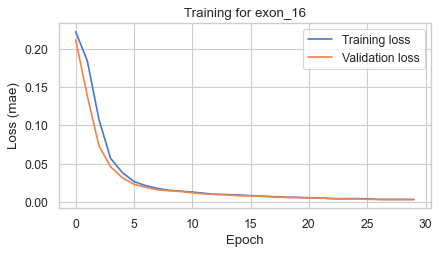

10/10 [==============================] - 0s 4ms/step


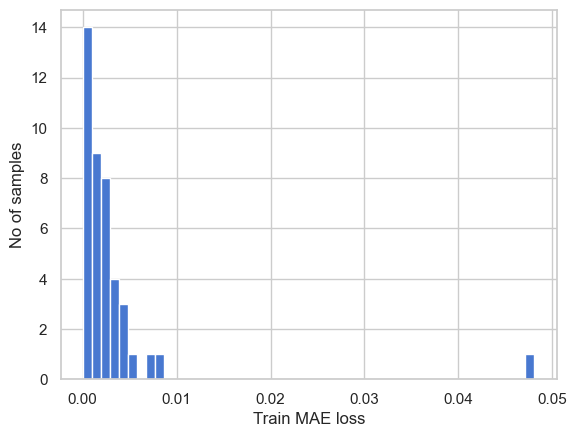

Reconstruction error threshold: 0.04807329177856445
1/1 [==============================] - 0s 30ms/step
Anomaly detection - exon_16
Count of anomalous nucleotides:  0
======== End of processing exon_16 ========  

===========Training for exon_17============
Epoch 1/30
15/15 - 2s - loss: 0.2372 - val_loss: 0.2296 - 2s/epoch - 134ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2084 - val_loss: 0.1774 - 137ms/epoch - 9ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1565 - val_loss: 0.1324 - 139ms/epoch - 9ms/step
Epoch 4/30
15/15 - 0s - loss: 0.1165 - val_loss: 0.1006 - 143ms/epoch - 10ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0892 - val_loss: 0.0791 - 140ms/epoch - 9ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0718 - val_loss: 0.0645 - 150ms/epoch - 10ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0597 - val_loss: 0.0562 - 142ms/epoch - 9ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0518 - val_loss: 0.0479 - 137ms/epoch - 9ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0450 - val_loss: 0.0413 - 136ms/epoch - 9ms/step
Epoch 10/30


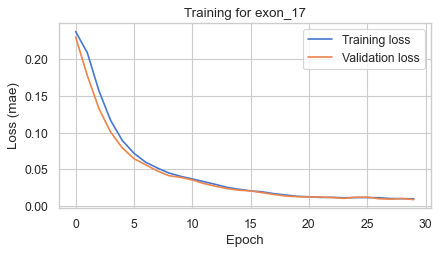

10/10 [==============================] - 0s 4ms/step


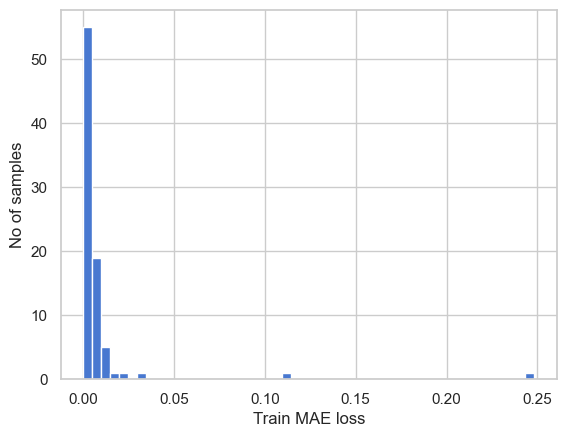

Reconstruction error threshold: 0.2482573390007019
1/1 [==============================] - 0s 27ms/step
Anomaly detection - exon_17
Count of anomalous nucleotides:  0
======== End of processing exon_17 ========  



In [17]:
for exon_n in range(len(referent_exons)):
    
    #Creating the exon names
    exon_name = 'exon_0' + str(exon_n+1) if exon_n+1 < 10 else 'exon_' + str(exon_n+1)
    
    #Converting the sequences into required shape
    reference_set = create_dataset(referent_exons[exon_n])
    reference_set = reference_set.reshape(COPY_COUNT, len(referent_exons[exon_n]), 1)
    
    #Calling the autoencoder
    autoencoder = MutationDetector(reference_set.shape[1])
    
    #Compile the model using optimizer adam and loss: mean absolute error
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mae")

    tr_title = 'Training for {}'.format(exon_name)
    print( '==========='+ tr_title +'============')
    
    #Fitting the model
    history = autoencoder.fit(reference_set, reference_set,
        epochs=30,
        batch_size=16,
        validation_split=0.2,
        verbose=2)
    
    print(autoencoder.show_summary())

    #Plot training result
    training_plot(history, tr_title) 
    
    """
    Predict the referent data to calculate the training loss
    it is needed to determine the reconstruction loss
    """
    predict = autoencoder.predict(reference_set)

    # Get reconstruction loss threshold.
    threshold = calculate_threshold(predict[0], reference_set[0])
    print("Reconstruction error threshold:", threshold)
    
    # Loading patient exon sequence
    patient_set = patient_exons[exon_n].reshape(1,  len(referent_exons[exon_n]), 1)
    test_predict = autoencoder.predict(patient_set)
    
    #Searching for anomalies
    detect_anomalies(test_predict[0] , patient_set[0], threshold, exon_name)
    
    print("======== End of processing {} ========  \n".format(exon_name))


In [18]:
"Mutations of BRCA1 gene were found in: {}".format(anomalous_exon_names)

"Mutations of BRCA1 gene were found in: ['exon_02', 'exon_04', 'exon_07', 'exon_11', 'exon_12', 'exon_13', 'exon_14']"